In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Read in all the words.
words = open('names.txt', 'r').read().splitlines()
print(f"Total amount of words: {len(words)}")

Total amount of words: 32033


In [4]:
# Build the vocabulary of characters and mappings to/from integers.
chars = sorted(list(set(''.join(words))))
stoi = {ch: ix + 1 for ix, ch in enumerate(chars)}
stoi['.'] = 0
itos = {ix: ch for ch, ix in stoi.items()}
vocabulary_size = len(itos)
print(f"Vocabulary size: {vocabulary_size}")

Vocabulary size: 27


In [5]:
def build_dataset(words: list[str], context_size: int = 3, logging: bool = False) -> tuple[torch.tensor]:
    """
    Given an list of string words, creates input and output targets.
    Args:
        words(list[int], shape=[n]): List of all words to sample examples from.
        context_size(int)          : How many characters are considered for prediction.
        logging(bool)              : Whether to print builded examples or not.
    Returns:
        X(torch.tensor, shape=[m, contex size]): Input tensor, where m is number of examples.
        Y(torch.tensor, shape=[m])             : Target tensor, where m is number of examples.
    """
    X, Y = [], []
    for word in words:
        context = [0] * context_size
        for ch in word + '.':
            X.append(context)
            Y.append(stoi[ch])
            context = context[1:] + [stoi[ch]]
    X, Y = torch.tensor(X), torch.tensor(Y)
    if logging:
        print(f'Input: {X.shape}, Output: {Y.shape}')
    return X, Y

In [6]:
from typing import Any


class Linear():
    def __init__(self, fan_in: int, fan_out: int, bias: bool = True) -> None:
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5  # kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x: torch.tensor) -> torch.tensor:
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias      
        return self.out

    def parameters(self) -> list:
        return [self.weight] + ([self.bias] if self.bias is not None else [])
    

class BatchNorm1d():
    def __init__(self, dim: int, eps: float = 1e-5, momentum: float = 0.1) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained wdith a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x: torch.tensor) -> torch.tensor:
        if self.training:
            # check input's dimensionality
            if x.dim() == 2:
                dim = 0
            elif x.dim() == 3:
                dim = (0, 1)
            else:
                raise Exception(f'Able to process 2D or 3D tensors only, received {x.dim()}D tensor')
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = self.running_mean * (1.0 - self.momentum) + xmean * self.momentum
                self.running_var = self.running_var * (1.0 - self.momentum) + xvar * self.momentum
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]


class Tanh():
    def __call__(self, x: torch.tensor) -> torch.tensor:
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    

class Embedding():
    def __init__(self, num_embeddings: int, embedding_dim: int) -> None:
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX: torch.tensor) -> torch.tensor:
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self) -> list[torch.tensor]:
        return [self.weight]
    

class FlattenConsecutive():
    def __init__(self, n: int) -> None:
        self.n = n  # number of consecutice elements

    def __call__(self, x: torch.tensor) -> torch.tensor:
        B, T, C = x.shape
        x = x.view(B, T // self.n, C * self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self) -> list:
        return []
    

class Sequential():
    def __init__(self, layers: list) -> None:
        self.layers = layers
    
    def __call__(self, x: Any) -> Any:
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self) -> list:
        return [p for layer in self.layers for p in layer.parameters()]

In [7]:
torch.manual_seed(13);

In [8]:
# Split the dataset on train, development and test set.
import random
random.seed(13)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)


block_size = 8  # how many charecters do we take to predict the next one?
Xtrain, Ytrain = build_dataset(words[:n1], block_size, True)     # 80%
Xdevelop, Ydevelop = build_dataset(words[n1:n2], block_size, True) # 10%
Xtest, Ytest = build_dataset(words[n2:], block_size, True)     # 10%

Input: torch.Size([182597, 8]), Output: torch.Size([182597])
Input: torch.Size([22761, 8]), Output: torch.Size([22761])
Input: torch.Size([22788, 8]), Output: torch.Size([22788])


In [9]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split: str, evaluated_model: Sequential) -> None:
    """
    Given a split name, evaluates it and prints the result.
    Args:
        split(str): name of the dataset split you'd like to evaluate.
    """
    x, y = {  # Sets are global!
        'train': (Xtrain, Ytrain),
        'dev': (Xdevelop, Ydevelop),
        'test': (Xtest, Ytest)
    }[split]
    
    # swith to evaluation mode
    for layer in evaluated_model.layers:
        layer.training = False

    logits =  evaluated_model(x)
    loss = F.cross_entropy(logits, y)

    # switch back to training mode
    for layer in evaluated_model.layers:
        layer.training = True
    
    return loss.item()

In [81]:
def train_model(
        n_embd: int, n_hidden: int, vocab_size: int,  # model's paramerers
        max_steps: int, batch_size: int, lr: float,   # training settings
        Xtr: torch.tensor, Ytr: torch.tensor          # training and target sets
) -> list:
    """
    Inintializes the models using given parameters and trains it with given settings on given sets.
    """

    model = Sequential([
        Embedding(vocab_size, n_embd), 
        FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
        FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
        FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
        Linear(n_hidden, vocab_size)
    ])

    with torch.no_grad():
        model.layers[-1].weight *= 0.1  # make last layer less confident
    parameters = model.parameters()
    print(sum(p.nelement() for p in parameters))
    for p in parameters:
        p.requires_grad = True
    
    lossi = []
    for i in range(max_steps):
        """Mini-batch construct"""
        ix = torch.randint(0, Xtr.shape[0], (batch_size,))
        Xb, Yb = Xtr[ix], Ytr[ix]  # batch X, Y
        
        """Forward pass"""
        logits = model(Xb)
        loss = F.cross_entropy(logits, Yb)  # loss function
        
        """Backward pass"""
        for p in parameters:
            p.grad = None
        loss.backward()
        
        """Update"""
        lr = 1.0 if i < 100000 else 0.01  # learning step decay
        for p in parameters:
            p.data += -lr * p.grad
        
        """Track stats"""
        if i % 1000 == 0:
            print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
        lossi.append(loss.log10().item())

    """Plotting"""
    # plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))
    train_loss = split_loss('train', model)
    deevlop_loss = split_loss('dev', model)
    return [train_loss, deevlop_loss, lossi]

In [82]:
embedding_dim = 10  # the dimensionality of the character embedding vectors
hidden_neurons = 50  # the number of neurons in the hidden layer of the MLP
learning_rate = 0.7327
iterations = 10000
minibatch_size = 256

In [ ]:
# learning rate = 0.7327
trains, develops = [], []
lrs = torch.linspace(0.732, 0.733, 5).tolist()
for i in range(len(lrs)):
    learning_rate = lrs[i]
    losses = train_model(
        embedding_dim,
        hidden_neurons,
        vocabulary_size,
        iterations,
        minibatch_size,
        learning_rate,
        Xtrain, Ytrain
    )
    trains.append(losses[0])
    develops.append(losses[1])

    print('-'*40)
    print(f'{learning_rate = }')
    print(' Train | Develop')
    print(losses)
    print('-'*40)

plt.plot(lrs, trains)
plt.plot(lrs, develops)

In [ ]:
# Bigger size is better, 256 seemed best on 8 context length
trains, develops = [], []
batch_sizes = [256, 512]
for i in range(len(batch_sizes)):
    minibatch_size = batch_sizes[i]
    losses = train_model(
        embedding_dim,
        hidden_neurons,
        vocabulary_size,
        iterations,
        minibatch_size,
        learning_rate,
        Xtrain, Ytrain
    )
    trains.append(losses[0])
    develops.append(losses[1])

    print('-'*40)
    print(f'{minibatch_size = }')
    print(' Train | Develop')
    print(losses)
    print('-'*40)

plt.plot(batch_sizes, trains)
plt.plot(batch_sizes, develops)

21419
      0/   5000: 3.2892
   1000/   5000: 2.1405
   2000/   5000: 2.5291
   3000/   5000: 2.5391
   4000/   5000: 2.6818
----------------------------------------
embedding_dim = 4
 Train | Develop
[2.2949652671813965, 2.310877561569214]
----------------------------------------
22071
      0/   5000: 3.3083
   1000/   5000: 2.3823
   2000/   5000: 2.1045
   3000/   5000: 2.2277
   4000/   5000: 2.3131
----------------------------------------
embedding_dim = 8
 Train | Develop
[2.3201375007629395, 2.341668128967285]
----------------------------------------
22723
      0/   5000: 3.3071
   1000/   5000: 2.4262
   2000/   5000: 2.1094
   3000/   5000: 2.3081
   4000/   5000: 2.6915
----------------------------------------
embedding_dim = 12
 Train | Develop
[2.2364723682403564, 2.259121894836426]
----------------------------------------
23375
      0/   5000: 3.2848
   1000/   5000: 2.5603
   2000/   5000: 1.9599
   3000/   5000: 2.3001
   4000/   5000: 2.7498
------------------------

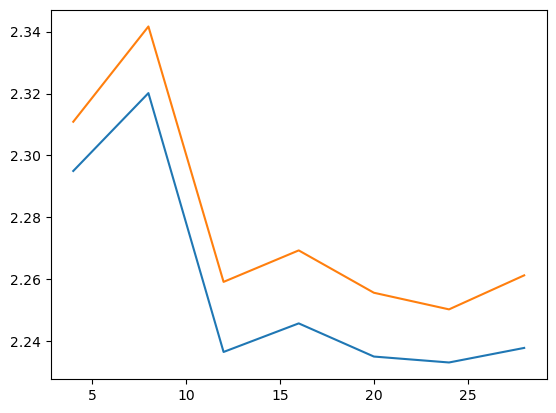

In [39]:
# 10, 11 or 27 are all good, I'll use 10 for now
trains, develops = [], []
embdims = [4, 8, 12, 16, 20, 24, 28]
for i in range(len(embdims)):
    embedding_dim = embdims[i]
    losses = train_model(
        embedding_dim,
        hidden_neurons,
        vocabulary_size,
        iterations,
        minibatch_size,
        learning_rate,
        Xtrain, Ytrain
    )
    trains.append(losses[0])
    develops.append(losses[1])

    print('-'*40)
    print(f'{embedding_dim = }')
    print(' Train | Develop')
    print(losses)
    print('-'*40)

plt.plot(embdims, trains)
plt.plot(embdims, develops)

10782
      0/   5000: 3.2987
   1000/   5000: 2.1335
   2000/   5000: 2.1300
   3000/   5000: 1.9120
   4000/   5000: 2.3214
----------------------------------------
hidden_neurons = 45
 Train | Develop
[2.2551393508911133, 2.2709007263183594]
----------------------------------------
11624
      0/   5000: 3.3192
   1000/   5000: 2.5406
   2000/   5000: 2.5059
   3000/   5000: 2.8639
   4000/   5000: 1.8649
----------------------------------------
hidden_neurons = 47
 Train | Develop
[2.251237630844116, 2.2756199836730957]
----------------------------------------
12947
      0/   5000: 3.2989
   1000/   5000: 2.5629
   2000/   5000: 2.5851
   3000/   5000: 2.1109
   4000/   5000: 2.2864
----------------------------------------
hidden_neurons = 50
 Train | Develop
[2.2261550426483154, 2.2459065914154053]
----------------------------------------
13869
      0/   5000: 3.2996
   1000/   5000: 2.1582
   2000/   5000: 2.4378
   3000/   5000: 2.1884
   4000/   5000: 2.0483
-----------------

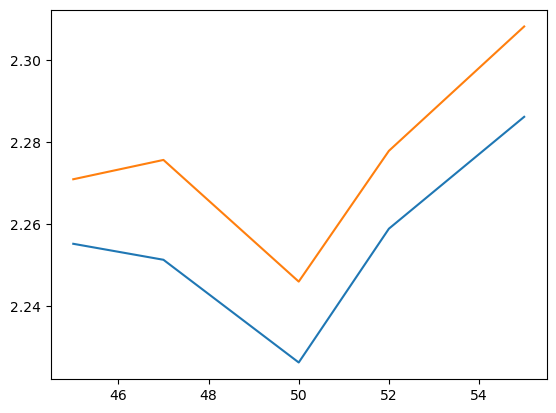

In [44]:
# 50 is good
trains, develops = [], []
neurons_amounts = [45, 47, 50, 52, 55]
for i in range(len(neurons_amounts)):
    hidden_neurons = neurons_amounts[i]
    losses = train_model(
        embedding_dim,
        hidden_neurons,
        vocabulary_size,
        iterations,
        minibatch_size,
        learning_rate,
        Xtrain, Ytrain
    )
    trains.append(losses[0])
    develops.append(losses[1])

    print('-'*40)
    print(f'{hidden_neurons = }')
    print(' Train | Develop')
    print(losses)
    print('-'*40)

plt.plot(neurons_amounts, trains)
plt.plot(neurons_amounts, develops)

In [83]:
train, develop, losses= train_model(
    embedding_dim,
    hidden_neurons,
    vocabulary_size,
    iterations,
    minibatch_size,
    learning_rate,
    Xtrain, Ytrain
)

losses = torch.tensor(losses).view(-1, 1000).sum(1).tolist()

12947
      0/  10000: 3.2970
   1000/  10000: 2.2134
   2000/  10000: 2.0915
   3000/  10000: 2.0177
   4000/  10000: 1.9099
   5000/  10000: 1.9392
   6000/  10000: 2.0674
   7000/  10000: 2.0290
   8000/  10000: 2.0730
   9000/  10000: 2.0110


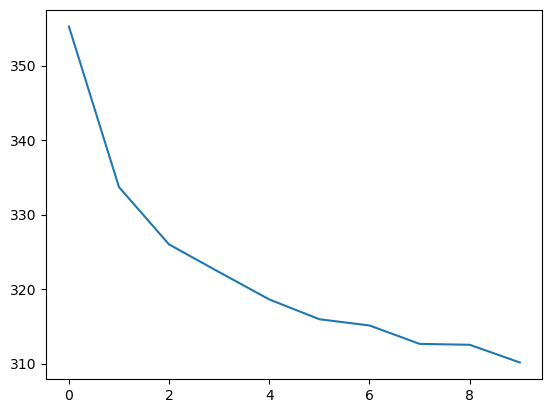

In [84]:
plt.plot(losses)

In [85]:
train, develop

(2.0877525806427, 2.1524131298065186)

In [ ]:
""" Sampling from model
# Sample from the model.
g = torch.Generator().manual_seed(13 + 10)
for _ in range (20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context])) # (1, block_size, n_embd)
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '' token, break
        if ix == 0:
            break
    print("".join(itos[i] for i in out)) # decode and print the generated word
"""